In [43]:
import sympy
from sympy import init_printing
from sympy import MutableDenseMatrix
# init_printing(use_latex='png')

# Use IPython's Latex capabilities to avoid a bug in Sympy's matrix printing
from IPython.display import display, Math, Latex

import numpy as np
import pyamg
from scipy import sparse
from scipy import ndimage
from scipy.linalg import solve
import rasterio as rio
from geoblend.coefficient_matrix import create_coefficient_matrix

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['image.interpolation'] = 'none'
mpl.rcParams['image.cmap'] = 'cubehelix'

%matplotlib inline

np.set_printoptions(linewidth=200)

### Poisson blend derivation

Solving the poisson equation for image blending

In [44]:
display(Math("\int \int_{\Omega} | f - \mathbf{v} | ^{2} \quad where \quad f |_{\delta \Omega} = f^{*}_{\delta \Omega}"))

<IPython.core.display.Math object>

In [45]:
def display_matrix(m):
    """
    Helper function to display the coefficient
    matrix.
    """
    
    if type(m) == MutableDenseMatrix:
        tex = sympy.latex(m)
    elif type(m) == np.ndarray:
        tex = sympy.latex(sympy.Matrix(mask.astype(np.int8).tolist()))
    else:
        # Crazy-ness to get integer represention ...
        tex = sympy.latex(sympy.Matrix(m.toarray().astype(np.int8).tolist()))
    
    display(Math(tex))

In [46]:
def create_auxiliary_equation(mask):
    """
    Create a sympy representation of the auxiliary equation corresponding
    to the Poisson equation.
    
    This prevents me from tedious, error-proned, hand-written algebra.
    """
    
    height, width = mask.shape
    x_domain = range(width)
    y_domain = range(height)
    
    # Create symbolic variables representing the unknown image
    # and the known gradient that will be imposed on the unknown image.
    
    # Note: One variable per pixel. f, s, c are pixel-aligned.
    # f represents the unknown image
    # s represents the source image
    # c represents the boundary conditions
    f = [ sympy.symbols(' '.join([ 'f%d%d' % (i, j) for j in y_domain ])) for i in x_domain ]
    s = [ sympy.symbols(' '.join([ 's%d%d' % (i, j) for j in y_domain ])) for i in x_domain ]
    c = [ sympy.symbols(' '.join([ 'c%d%d' % (i, j) for j in y_domain ])) for i in x_domain ]
    
    # Create the variable that will comprise the auxiliary equation.
    equation = 0
    
    for j in y_domain:
        for i in x_domain:
            
            if mask[j][i] == 0:
                continue
            
            #
            # Define the index of the 4-connected neighbors
            #
            
            # For a pixel p with indices (i, j), the
            # 4-connected neighbors are defined by the
            # surrounding 3x3 pixel grid as:
            #
            # - N - 
            # W p E
            # - S - 
            
            nj, ni = j - 1, i
            sj, si = j + 1, i
            ej, ei = j, i + 1
            wj, wi = j, i - 1
            
            if nj in y_domain:
                
                if mask[nj][ni] == 0:
                    equation += (f[i][j] - c[ni][nj] - (s[i][j] - s[ni][nj])) ** 2
                else:
                    equation += (f[i][j] - f[ni][nj] - (s[i][j] - s[ni][nj])) ** 2
            
            if sj in y_domain:
                
                if mask[sj][si] == 0:
                    equation += (f[i][j] - c[si][sj] - (s[i][j] - s[si][sj])) ** 2
                else:
                    equation += (f[i][j] - f[si][sj] - (s[i][j] - s[si][sj])) ** 2

            if ei in x_domain:
                
                if mask[ej][ei] == 0:
                    equation += (f[i][j] - c[ei][ej] - (s[i][j] - s[ei][ej])) ** 2
                else:
                    equation += (f[i][j] - f[ei][ej] - (s[i][j] - s[ei][ej])) ** 2
            
            if wi in x_domain:
                
                if mask[wj][wi] == 0:
                    equation += (f[i][j] - c[wi][wj] - (s[i][j] - s[wi][wj])) ** 2
                else:
                    equation += (f[i][j] - f[wi][wj] - (s[i][j] - s[wi][wj])) ** 2
    
    return equation, f, s, c

In [47]:
mask1 = np.array([
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
  [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
  [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
  [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
  [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
  [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
], dtype=np.uint8)

In [140]:
mask2 = np.array([
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
  [0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
  [0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
  [0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
  [0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
  [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
], dtype=np.uint8)
mask2

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [49]:
# with rio.drivers():
#     with rio.open("test2/20150705_014439_081f_analytic.tif") as src:
#         mask3 = src.read(4).astype(np.uint8)
#         mask3[np.nonzero(mask3)] = 1
# mask3

In [169]:
mask4 = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
], dtype=np.uint8)

In [170]:
# eq1, f1, s1, c1 = create_auxiliary_equation(mask1)
# eq2, f2, s2, c2 = create_auxiliary_equation(mask2)
# eq3, f3, s3, c3 = create_auxiliary_equation(mask3)
eq4, f4, s4, c4 = create_auxiliary_equation(mask4)

In [171]:
def linearize_system(mask, equation, f):
    
    indices = np.nonzero(mask)
    return [
        sympy.diff(equation, f[idx[1]][idx[0]])
        for idx in zip(*indices)
    ]

In [172]:
# system1 = linearize_system(mask1, eq1, f1)
# system2 = linearize_system(mask2, eq2, f2)
# system3 = linearize_system(mask3, eq3, f3)
system4 = linearize_system(mask4, eq4, f4)

In [173]:
# mat1 = sympy.Matrix(system1)
# mat2 = sympy.Matrix(system2)
# mat3 = sympy.Matrix(system3)
mat4 = sympy.Matrix(system4)

In [174]:
# display_matrix(mat1)
# display_matrix(mat2)
# display_matrix(mat3)
# display_matrix(mat4)

In [175]:
def get_unknown_vector(mask, f):
    
    indices = np.nonzero(mask)
    return [
        f[idx[1]][idx[0]]
        for idx in zip(*indices)
    ]

In [177]:
# vec1 = get_unknown_vector(mask1, f1)
# vec2 = get_unknown_vector(mask2, f2)
# vec3 = get_unknown_vector(mask3, f3)
vec4 = get_unknown_vector(mask4, f4)

In [179]:
# coeff1 = mat1.jacobian(vec1)
# coeff2 = mat2.jacobian(vec2)
# coeff3 = mat3.jacobian(vec3)
coeff4 = mat4.jacobian(vec4)

In [181]:
# display_matrix(coeff1)
# display_matrix(coeff2)
# display_matrix(coeff3)
coeff4

Matrix([
[12, -4,  0,  0, -4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
[-4, 14, -4,  0,  0, -4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
[ 0, -4, 14, -4,  0,  0, -4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
[ 0,  0, -4, 12,  0,  0,  0, -4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 

In [26]:
# a = np.array(coeff3.tolist())
# np.save('matrix.npy', a)

In [95]:
# mask3

### Sample data

In [150]:
def get_replacements(source, reference, mask, f, c, s):
    
    boundary_replacements = []
    field_replacements = []
    
    # Replace boundaries with values from the reference image
    
    height, width = mask.shape
    for j in range(height):
        for i in range(width):
            
            boundary_replacements.append((c[i][j], reference[j][i]))
            field_replacements.append((s[i][j], source[j][i]))

    return boundary_replacements + field_replacements

In [151]:
def get_null_replacements_for_unknowns(mask, f):
    """
    Zero out unknown values from the system to get
    a grasp on the RHS.
    """
    replacements = []
    
    height, width = mask.shape
    for j in range(height):
        for i in range(width):
            replacements.append((f[i][j], 0))

    return replacements

In [136]:
null_replacements = get_null_replacements_for_unknowns(mask1, f1)

In [139]:
print mask1
display_matrix(mat1.subs(null_replacements))

[[0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 0]
 [0 0 0 0 0 0 0 0 0 0]]


<IPython.core.display.Math object>

#### Rectangular case

In [85]:
source1 = np.array([
    [502, 527, 545, 517, 518, 492, 457, 562, 405, 420],
    [605, 512, 444, 473, 465, 496, 527, 445, 387, 397],
    [543, 446, 440, 393, 491, 472, 471, 417, 439, 371],
    [513, 476, 494, 448, 470, 491, 492, 443, 559, 514],
    [454, 487, 498, 471, 402, 484, 471, 377, 574, 452],
    [507, 478, 499, 484, 381, 372, 249, 333, 607, 410],
    [451, 497, 497, 392, 389, 476, 357, 366, 400, 464],
    [485, 517, 567, 531, 443, 324, 370, 408, 361, 464]
], dtype=np.uint16)

reference1 = np.array([
    [611, 573, 639, 564, 626, 588, 556, 503, 458, 461],
    [689, 559, 532, 550, 572, 601, 521, 466, 469, 437],
    [631, 530, 513, 504, 545, 516, 428, 444, 447, 430],
    [648, 566, 518, 514, 592, 537, 518, 468, 658, 559],
    [553, 587, 556, 544, 423, 574, 546, 452, 456, 387],
    [590, 598, 583, 564, 408, 389, 219, 498, 501, 479],
    [565, 572, 564, 436, 442, 638, 208, 382, 466, 455],
    [566, 545, 570, 507, 429, 378, 425, 474, 425, 466]
], dtype=np.uint16)

In [86]:
replacements1 = get_replacements(source1, reference1, mask1, f1, c1, s1)

In [87]:
replacements1

[(c00, 611),
 (c10, 573),
 (c20, 639),
 (c30, 564),
 (c40, 626),
 (c50, 588),
 (c60, 556),
 (c70, 503),
 (c80, 458),
 (c90, 461),
 (c01, 689),
 (c11, 559),
 (c21, 532),
 (c31, 550),
 (c41, 572),
 (c51, 601),
 (c61, 521),
 (c71, 466),
 (c81, 469),
 (c91, 437),
 (c02, 631),
 (c12, 530),
 (c22, 513),
 (c32, 504),
 (c42, 545),
 (c52, 516),
 (c62, 428),
 (c72, 444),
 (c82, 447),
 (c92, 430),
 (c03, 648),
 (c13, 566),
 (c23, 518),
 (c33, 514),
 (c43, 592),
 (c53, 537),
 (c63, 518),
 (c73, 468),
 (c83, 658),
 (c93, 559),
 (c04, 553),
 (c14, 587),
 (c24, 556),
 (c34, 544),
 (c44, 423),
 (c54, 574),
 (c64, 546),
 (c74, 452),
 (c84, 456),
 (c94, 387),
 (c05, 590),
 (c15, 598),
 (c25, 583),
 (c35, 564),
 (c45, 408),
 (c55, 389),
 (c65, 219),
 (c75, 498),
 (c85, 501),
 (c95, 479),
 (c06, 565),
 (c16, 572),
 (c26, 564),
 (c36, 436),
 (c46, 442),
 (c56, 638),
 (c66, 208),
 (c76, 382),
 (c86, 466),
 (c96, 455),
 (c07, 566),
 (c17, 545),
 (c27, 570),
 (c37, 507),
 (c47, 429),
 (c57, 378),
 (c67, 425),

In [88]:
display_matrix(mat1.subs(replacements1))

<IPython.core.display.Math object>

In [91]:
mat1.subs(replacements1)

Matrix([
[                 12*f11 - 4*f12 - 4*f21 - 2844.0],
[         -4*f11 + 14*f21 - 4*f22 - 4*f31 - 704.0],
[        -4*f21 + 14*f31 - 4*f32 - 4*f41 - 1508.0],
[         -4*f31 + 14*f41 - 4*f42 - 4*f51 - 886.0],
[        -4*f41 + 14*f51 - 4*f52 - 4*f61 - 1280.0],
[        -4*f51 + 14*f61 - 4*f62 - 4*f71 - 1928.0],
[         -4*f61 + 14*f71 - 4*f72 - 4*f81 - 788.0],
[                -4*f71 + 12*f81 - 4*f82 - 1294.0],
[         -4*f11 + 14*f12 - 4*f13 - 4*f22 - 708.0],
[  -4*f12 - 4*f21 + 16*f22 - 4*f23 - 4*f32 + 68.0],
[-4*f22 - 4*f31 + 16*f32 - 4*f33 - 4*f42 + 1120.0],
[ -4*f32 - 4*f41 + 16*f42 - 4*f43 - 4*f52 - 656.0],
[ -4*f42 - 4*f51 + 16*f52 - 4*f53 - 4*f62 + 244.0],
[  -4*f52 - 4*f61 + 16*f62 - 4*f63 - 4*f72 + 96.0],
[ -4*f62 - 4*f71 + 16*f72 - 4*f73 - 4*f82 + 520.0],
[         -4*f72 - 4*f81 + 14*f82 - 4*f83 - 812.0],
[        -4*f12 + 14*f13 - 4*f14 - 4*f23 - 1226.0],
[ -4*f13 - 4*f22 + 16*f23 - 4*f24 - 4*f33 - 456.0],
[ -4*f23 - 4*f32 + 16*f33 - 4*f34 - 4*f43 + 144.0],
[ -

In [154]:
# Numpy representation of the valued elements above
b1 = np.array([
    2844., 704., 1508., 886., 1280., 1928., 788., 1294.,
    708., -68., -1120., 656., -244., -96., -520., 812.,
    1226., 456., -144., 192.,   184.,   368.,  -292.,
    2092.,  1208.,   164.,   208.,  -792.,   800.,  1128.,
    -1252.,  1734.,   926.,   156.,   772.,  -492., -408.,
    -2148., -1068.,  3408.,  2348.,  1412.,   -40.,   422.,
    2300.,   744.,   896.,  1018.
])

In [155]:
A1 = np.array(coeff1.tolist(), dtype=np.int32)

In [156]:
blended1 = np.copy(reference1)
blended1[np.nonzero(mask1)] = solve(A1, b1)

In [166]:
blended1.tolist()

[[611, 573, 639, 564, 626, 588, 556, 503, 458, 461],
 [689, 584, 517, 540, 537, 563, 583, 475, 426, 437],
 [631, 523, 511, 459, 554, 530, 521, 457, 480, 430],
 [648, 558, 564, 510, 527, 543, 538, 483, 595, 559],
 [553, 561, 561, 526, 452, 531, 514, 413, 596, 387],
 [590, 543, 553, 529, 423, 416, 292, 373, 645, 479],
 [565, 556, 538, 422, 419, 517, 401, 410, 436, 455],
 [566, 545, 570, 507, 429, 378, 425, 474, 425, 466]]

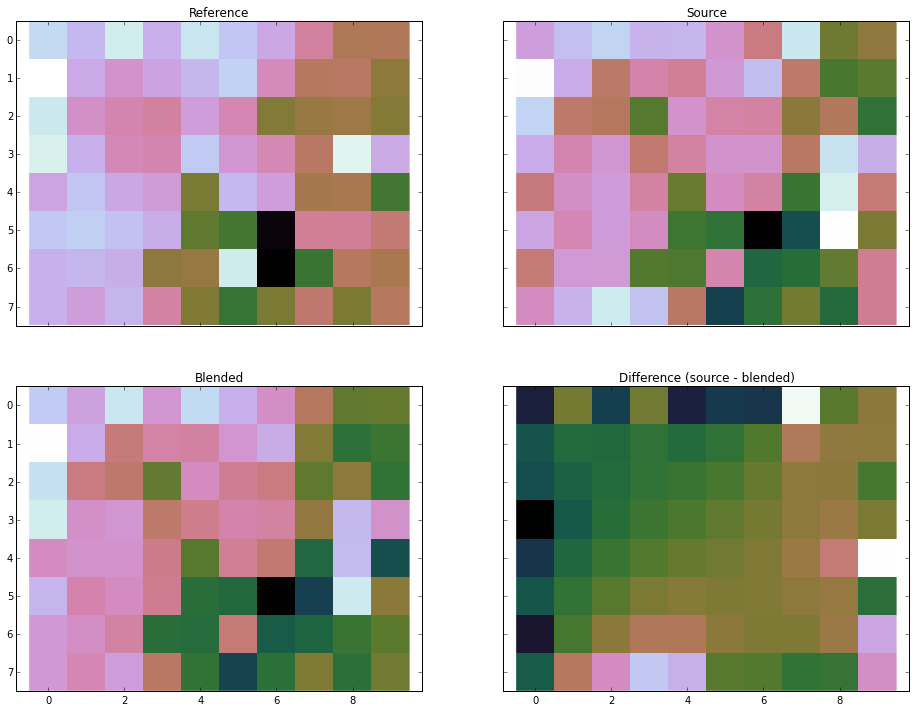

In [157]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(16, 12))

ax1.set_title('Reference')
ax1.imshow(reference1)

ax2.set_title('Source')
ax2.imshow(source1)

ax3.set_title('Blended')
ax3.imshow(blended1)

ax4.set_title('Difference (source - blended)')
ax4.imshow(source1.astype(np.float) - blended1.astype(np.float))

#### Non-rectangular small case

In [158]:
# Data is the same as rectangular case. Mask is different above.

source2 = np.array([
    [502, 527, 545, 517, 518, 492, 457, 562, 405, 420],
    [605, 512, 444, 473, 465, 496, 527, 445, 387, 397],
    [543, 446, 440, 393, 491, 472, 471, 417, 439, 371],
    [513, 476, 494, 448, 470, 491, 492, 443, 559, 514],
    [454, 487, 498, 471, 402, 484, 471, 377, 574, 452],
    [507, 478, 499, 484, 381, 372, 249, 333, 607, 410],
    [451, 497, 497, 392, 389, 476, 357, 366, 400, 464],
    [485, 517, 567, 531, 443, 324, 370, 408, 361, 464]
], dtype=np.uint16)

reference2 = np.array([
    [611, 573, 639, 564, 626, 588, 556, 503, 458, 461],
    [689, 559, 532, 550, 572, 601, 521, 466, 469, 437],
    [631, 530, 513, 504, 545, 516, 428, 444, 447, 430],
    [648, 566, 518, 514, 592, 537, 518, 468, 658, 559],
    [553, 587, 556, 544, 423, 574, 546, 452, 456, 387],
    [590, 598, 583, 564, 408, 389, 219, 498, 501, 479],
    [565, 572, 564, 436, 442, 638, 208, 382, 466, 455],
    [566, 545, 570, 507, 429, 378, 425, 474, 425, 466]
], dtype=np.uint16)

In [159]:
replacements2 = get_replacements(source2, reference2, mask2, f2, c2, s2)

In [184]:
mat2.subs(replacements2)

Matrix([
[                 12*f21 - 4*f22 - 4*f31 - 1958.0],
[                -4*f21 + 12*f31 - 4*f32 - 2636.0],
[        -4*f21 + 14*f22 - 4*f23 - 4*f32 - 1004.0],
[-4*f22 - 4*f31 + 16*f32 - 4*f33 - 4*f42 + 1120.0],
[                -4*f32 + 12*f42 - 4*f43 - 2742.0],
[                -4*f22 + 12*f23 - 4*f33 - 2672.0],
[ -4*f23 - 4*f32 + 16*f33 - 4*f34 - 4*f43 + 144.0],
[ -4*f33 - 4*f42 + 16*f43 - 4*f44 - 4*f53 - 192.0],
[        -4*f43 + 14*f53 - 4*f54 - 4*f63 - 1178.0],
[        -4*f53 + 14*f63 - 4*f64 - 4*f73 - 1182.0],
[                -4*f63 + 12*f73 - 4*f74 - 2092.0],
[        -4*f33 + 14*f34 - 4*f35 - 4*f44 - 1374.0],
[ -4*f34 - 4*f43 + 16*f44 - 4*f45 - 4*f54 + 792.0],
[ -4*f44 - 4*f53 + 16*f54 - 4*f55 - 4*f64 - 800.0],
[-4*f54 - 4*f63 + 16*f64 - 4*f65 - 4*f74 - 1128.0],
[-4*f64 - 4*f73 + 16*f74 - 4*f75 - 4*f84 + 1252.0],
[                        -4*f74 + 10*f84 - 4088.0],
[                -4*f34 + 12*f35 - 4*f45 - 2656.0],
[ -4*f35 - 4*f44 + 16*f45 - 4*f46 - 4*f55 + 492.0],
[ -

In [161]:
b2 = np.array([
        1958.,  2636.,  1004., -1120.,  2742.,  2672.,  -144.,
        192.,  1178.,  1182.,  2092.,  1374.,  -792.,   800.,
        1128., -1252.,  4088.,  2656.,  -492.,  -408., -1516.,
        1312.,  1300.,  2478.])

In [162]:
A2 = np.array(coeff2.tolist(), dtype=np.int32)

In [167]:
blended2 = np.copy(reference2)
blended2[np.nonzero(mask2)] = solve(A2, b2)

In [168]:
blended2.tolist()

[[611, 573, 639, 564, 626, 588, 556, 503, 458, 461],
 [689, 559, 513, 542, 572, 601, 521, 466, 469, 437],
 [631, 530, 508, 455, 550, 516, 428, 444, 447, 430],
 [648, 566, 558, 500, 509, 512, 495, 462, 658, 559],
 [553, 587, 556, 513, 429, 492, 463, 368, 556, 387],
 [590, 598, 583, 525, 397, 365, 215, 303, 501, 479],
 [565, 572, 564, 436, 394, 459, 208, 382, 466, 455],
 [566, 545, 570, 507, 429, 378, 425, 474, 425, 466]]

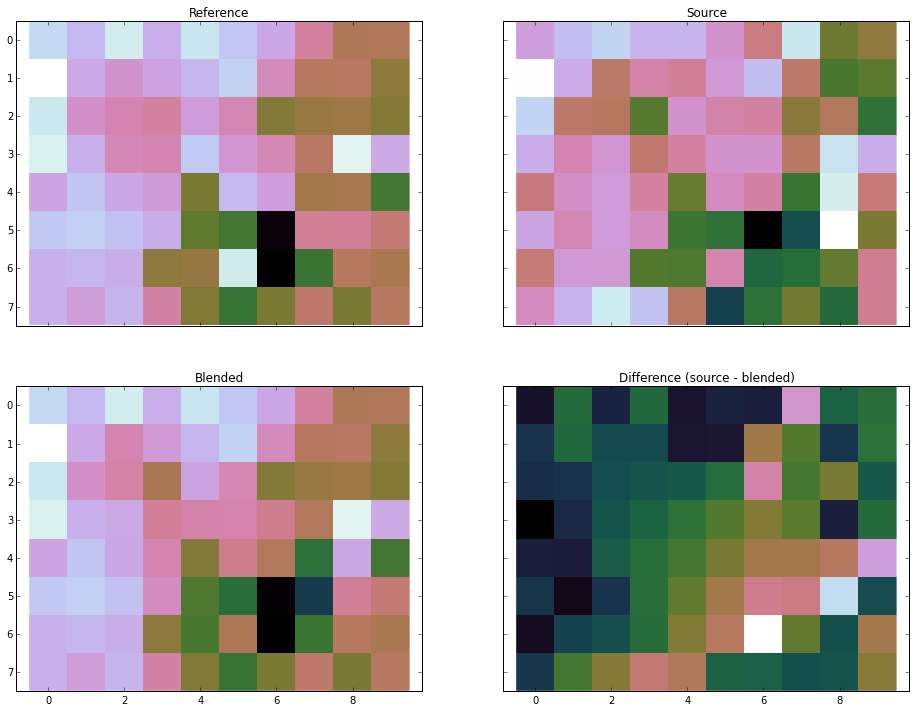

In [164]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(16, 12))

ax1.set_title('Reference')
ax1.imshow(reference2)

ax2.set_title('Source')
ax2.imshow(source2)

ax3.set_title('Blended')
ax3.imshow(blended2)

ax4.set_title('Difference (source - blended)')
ax4.imshow(source2.astype(np.float) - blended2.astype(np.float))

### Problematic Case
Bright pixels propagating from sharp mask boundary

In [182]:
source4 = np.array([
    [231, 199, 236, 235, 242, 243,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
    [266, 223, 236, 244, 248, 243, 227,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
    [221, 195, 230, 243, 235, 220, 221, 221,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
    [214, 200, 226, 228, 232, 228, 226, 217, 229,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
    [210, 199, 215, 213, 229, 231, 218, 208, 221, 235,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
    [227, 220, 227, 219, 207, 222, 208, 224, 210, 215, 262,   0,   0,   0,   0,   0,   0,   0,   0,   0],
    [224, 215, 218, 212, 202, 194, 216, 207, 209, 249, 232, 252,   0,   0,   0,   0,   0,   0,   0,   0],
    [226, 227, 221, 201, 189, 206, 208, 225, 236, 222, 255, 244, 222,   0,   0,   0,   0,   0,   0,   0],
    [222, 217, 209, 202, 196, 206, 227, 222, 233, 226, 250, 217, 245, 240,   0,   0,   0,   0,   0,   0],
    [211, 212, 210, 203, 199, 220, 218, 218, 230, 258, 248, 234, 233, 251, 273,   0,   0,   0,   0,   0]
], dtype=np.uint16)

reference4 = np.array([
    [277, 277, 277, 270, 270, 270, 270, 270, 270, 262, 262, 262, 262, 262, 262, 286, 286, 286, 286, 286],
    [288, 288, 288, 274, 274, 274, 270, 270, 270, 262, 262, 262, 262, 262, 262, 286, 286, 286, 286, 286],
    [288, 288, 288, 274, 274, 274, 274, 274, 274, 251, 251, 251, 251, 251, 251, 281, 281, 281, 281, 281],
    [288, 288, 288, 274, 274, 274, 274, 274, 274, 251, 251, 251, 251, 251, 281, 281, 281, 281, 281, 281],
    [288, 288, 288, 274, 274, 274, 274, 274, 274, 251, 251, 251, 251, 251, 281, 281, 281, 281, 281, 281],
    [288, 288, 288, 274, 274, 274, 274, 274, 274, 251, 251, 251, 251, 251, 281, 281, 281, 281, 281, 281],
    [288, 288, 288, 274, 274, 274, 274, 274, 274, 251, 251, 251, 251, 251, 281, 281, 281, 281, 281, 281],
    [290, 290, 290, 271, 271, 271, 271, 271, 271, 272, 272, 272, 272, 272, 279, 279, 279, 279, 279, 279],
    [290, 290, 290, 271, 271, 271, 271, 271, 271, 272, 272, 272, 272, 272, 279, 279, 279, 279, 279, 279],
    [290, 290, 290, 271, 271, 271, 271, 271, 271, 272, 272, 272, 272, 272, 279, 279, 279, 279, 279, 279]
], dtype=np.uint16)

In [183]:
replacements4 = get_replacements(source4, reference4, mask4, f4, c4, s4)

In [185]:
mat4.subs(replacements4)

Matrix([
[                     12*f11 - 4*f12 - 4*f21 - 1152.0],
[             -4*f11 + 14*f21 - 4*f22 - 4*f31 - 598.0],
[             -4*f21 + 14*f31 - 4*f32 - 4*f41 - 578.0],
[                    -4*f31 + 12*f41 - 4*f42 - 1178.0],
[             -4*f11 + 14*f12 - 4*f13 - 4*f22 - 252.0],
[      -4*f12 - 4*f21 + 16*f22 - 4*f23 - 4*f32 - 80.0],
[     -4*f22 - 4*f31 + 16*f32 - 4*f33 - 4*f42 - 140.0],
[      -4*f32 - 4*f41 + 16*f42 - 4*f43 - 4*f52 + 12.0],
[             -4*f42 + 14*f52 - 4*f53 - 4*f62 - 406.0],
[                    -4*f52 + 12*f62 - 4*f63 - 1060.0],
[             -4*f12 + 14*f13 - 4*f14 - 4*f23 - 468.0],
[     -4*f13 - 4*f22 + 16*f23 - 4*f24 - 4*f33 - 124.0],
[       -4*f23 - 4*f32 + 16*f33 - 4*f34 - 4*f43 + 8.0],
[      -4*f33 - 4*f42 + 16*f43 - 4*f44 - 4*f53 - 32.0],
[      -4*f43 - 4*f52 + 16*f53 - 4*f54 - 4*f63 - 12.0],
[      -4*f53 - 4*f62 + 16*f63 - 4*f64 - 4*f73 - 80.0],
[                    -4*f63 + 12*f73 - 4*f74 - 1064.0],
[             -4*f13 + 14*f14 - 4*f15 -

In [186]:
b4 = np.array([1152., 598., 578., 1178., 252., 80., 140., -12., 406., 1060., 468., 124., -8., 32., 12., 80., 1064., 402., -20., -156., 132., 108., -4., -192., 572., 2080., 638., 144., 68., -176., 192., -192., 252., -116., -384., 2360., 478., -12., 32., 24., -280., 188., -184., -264., 472., -360., 2124., 694., 116., -80., -196., 108., -168., 108., 220., -312., 288., 120., 1754., 1152., 526., 540., 500., 470., 740., 474., 608., 372., 756., 158., 792., 2564.])

In [197]:
img4 = np.copy(reference4).astype(np.float64)
img4[np.nonzero(mask4)] = b4

In [198]:
img4

array([[  277.,   277.,   277.,   270.,   270.,   270.,   270.,   270.,   270.,   262.,   262.,   262.,   262.,   262.,   262.,   286.,   286.,   286.,   286.,   286.],
       [  288.,  1152.,   598.,   578.,  1178.,   274.,   270.,   270.,   270.,   262.,   262.,   262.,   262.,   262.,   262.,   286.,   286.,   286.,   286.,   286.],
       [  288.,   252.,    80.,   140.,   -12.,   406.,  1060.,   274.,   274.,   251.,   251.,   251.,   251.,   251.,   251.,   281.,   281.,   281.,   281.,   281.],
       [  288.,   468.,   124.,    -8.,    32.,    12.,    80.,  1064.,   274.,   251.,   251.,   251.,   251.,   251.,   281.,   281.,   281.,   281.,   281.,   281.],
       [  288.,   402.,   -20.,  -156.,   132.,   108.,    -4.,  -192.,   572.,  2080.,   251.,   251.,   251.,   251.,   281.,   281.,   281.,   281.,   281.,   281.],
       [  288.,   638.,   144.,    68.,  -176.,   192.,  -192.,   252.,  -116.,  -384.,  2360.,   251.,   251.,   251.,   281.,   281.,   281.,   281.,   2

In [199]:
print img4.min(),img4.max()
print np.median(img4)

-384.0 2564.0
277.0


<matplotlib.colorbar.Colorbar instance at 0x11400f368>

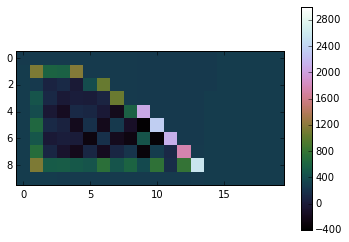

In [200]:
plt.imshow(img4, vmin=-400, vmax=3000)
plt.colorbar()

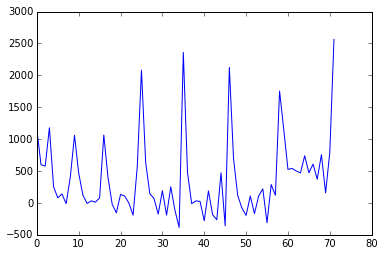

In [195]:
plt.plot(np.arange(0, b4.size), b4)

In [196]:
b4

array([ 1152.,   598.,   578.,  1178.,   252.,    80.,   140.,   -12.,   406.,  1060.,   468.,   124.,    -8.,    32.,    12.,    80.,  1064.,   402.,   -20.,  -156.,   132.,   108.,    -4.,  -192.,
         572.,  2080.,   638.,   144.,    68.,  -176.,   192.,  -192.,   252.,  -116.,  -384.,  2360.,   478.,   -12.,    32.,    24.,  -280.,   188.,  -184.,  -264.,   472.,  -360.,  2124.,   694.,
         116.,   -80.,  -196.,   108.,  -168.,   108.,   220.,  -312.,   288.,   120.,  1754.,  1152.,   526.,   540.,   500.,   470.,   740.,   474.,   608.,   372.,   756.,   158.,   792.,  2564.])

#### Big ole case

In [29]:
with rio.drivers():
    with rio.open('test2/landsat.tif') as src:
        reference3 = src.read(1)
    with rio.open('test2/20150705_014439_081f_analytic.tif') as src:
        source3 = src.read(1)
        field3 = (pyamg.gallery.poisson(source.shape) * source.ravel()).reshape(source.shape)

In [30]:
replacements3 = get_replacements(mask3, f3, g3, reference3, field3)

In [31]:
mat3.subs(replacements3)

Matrix([
[                          12*f115 - 4*f116 - 4*f125 + 558.0],
[               -4*f115 + 14*f125 - 4*f126 - 4*f135 + 2240.0],
[               -4*f125 + 14*f135 - 4*f136 - 4*f145 - 1608.0],
[               -4*f135 + 14*f145 - 4*f146 - 4*f155 + 2982.0],
[               -4*f145 + 14*f155 - 4*f156 - 4*f165 - 7848.0],
[                  -4*f155 + 14*f165 - 4*f166 - 4*f175 - 2.0],
[               -4*f165 + 14*f175 - 4*f176 - 4*f185 + 2028.0],
[                        -4*f175 + 12*f185 - 4*f186 - 4646.0],
[                          -4*f106 + 12*f96 - 4*f97 - 4268.0],
[                 14*f106 - 4*f107 - 4*f116 - 4*f96 + 7272.0],
[      -4*f106 - 4*f115 + 16*f116 - 4*f117 - 4*f126 - 5292.0],
[      -4*f116 - 4*f125 + 16*f126 - 4*f127 - 4*f136 - 5580.0],
[      -4*f126 - 4*f135 + 16*f136 - 4*f137 - 4*f146 + 2128.0],
[       -4*f136 - 4*f145 + 16*f146 - 4*f147 - 4*f156 + 868.0],
[      -4*f146 - 4*f155 + 16*f156 - 4*f157 - 4*f166 - 1728.0],
[      -4*f156 - 4*f165 + 16*f166 - 4*f167 - 4

In [32]:
sympy.diff(eq3, f3[12][5]).subs(symbolic_replacements3)

-2*c124 - 4*f115 + 14*f125 - 4*f126 - 4*f135 + 4*g115 + 2*g124 - 14*g125 + 4*g126 + 4*g135

In [49]:
display_matrix(mat3.subs(symbolic_replacements3))

In [33]:
mat3s = mat3.subs(replacements3)

In [24]:
mat3s

Matrix([
[                                          -4*f116 + 3480.0],
[                                          -4*f126 + 2786.0],
[                                          -4*f136 + 3458.0],
[                                          -4*f146 + 3446.0],
[                                          -4*f156 - 1592.0],
[                                          -4*f166 + 2488.0],
[                                          -4*f176 + 3922.0],
[                                           -4*f186 + 418.0],
[                                            -4*f97 + 472.0],
[                                 -4*f107 - 4*f116 + 9340.0],
[                        16*f116 - 4*f117 - 4*f126 - 7582.0],
[              -4*f116 + 16*f126 - 4*f127 - 4*f136 - 4774.0],
[              -4*f126 + 16*f136 - 4*f137 - 4*f146 - 1420.0],
[              -4*f136 + 16*f146 - 4*f147 - 4*f156 - 1582.0],
[              -4*f146 + 16*f156 - 4*f157 - 4*f166 - 2808.0],
[               -4*f156 + 16*f166 - 4*f167 - 4*f176 + 702.0],

In [26]:
vec3

[f115,
 f125,
 f135,
 f145,
 f155,
 f165,
 f175,
 f185,
 f96,
 f106,
 f116,
 f126,
 f136,
 f146,
 f156,
 f166,
 f176,
 f186,
 f196,
 f206,
 f87,
 f97,
 f107,
 f117,
 f127,
 f137,
 f147,
 f157,
 f167,
 f177,
 f187,
 f197,
 f207,
 f217,
 f78,
 f88,
 f98,
 f108,
 f118,
 f128,
 f138,
 f148,
 f158,
 f168,
 f178,
 f188,
 f198,
 f208,
 f218,
 f228,
 f69,
 f79,
 f89,
 f99,
 f109,
 f119,
 f129,
 f139,
 f149,
 f159,
 f169,
 f179,
 f189,
 f199,
 f209,
 f219,
 f229,
 f510,
 f610,
 f710,
 f810,
 f910,
 f1010,
 f1110,
 f1210,
 f1310,
 f1410,
 f1510,
 f1610,
 f1710,
 f1810,
 f1910,
 f2010,
 f2110,
 f2210,
 f2310,
 f511,
 f611,
 f711,
 f811,
 f911,
 f1011,
 f1111,
 f1211,
 f1311,
 f1411,
 f1511,
 f1611,
 f1711,
 f1811,
 f1911,
 f2011,
 f2111,
 f2211,
 f2311,
 f512,
 f612,
 f712,
 f812,
 f912,
 f1012,
 f1112,
 f1212,
 f1312,
 f1412,
 f1512,
 f1612,
 f1712,
 f1812,
 f1912,
 f2012,
 f2112,
 f2212,
 f2312,
 f2412,
 f413,
 f513,
 f613,
 f713,
 f813,
 f913,
 f1013,
 f1113,
 f1213,
 f1313,
 f1413,
 f1513,
 f

In [29]:
# x1 = sympy.solve(mat1.subs(replacements1))
# x2 = sympy.solve(mat2.subs(replacements2))
x3 = sympy.solve(mat3s)

In [30]:
x3

[]

In [21]:
def apply_blended_pixels(x, reference, f):
    img = np.copy(reference)
    
    height, width = reference.shape
    
    for j in range(height):
        for i in range(width):
            if x.has_key(f[i][j]):
                img[j][i] = x[f[i][j]]
    
    return img

In [22]:
x3

[]

In [52]:
# img1 = apply_blended_pixels(x1, reference, f1)
# img2 = apply_blended_pixels(x2, reference, f2)
img3 = apply_blended_pixels(x3, reference, f3)

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 4))
ax1.imshow(img1, vmin=300, vmax=750)
ax2.imshow(img2, vmin=300, vmax=750)

In [ ]:
print img1

In [ ]:
print img2